# Multi-Touch Attribution Modelling Project
Author: Olaoluwa J. Taiwo

## Project Brief

**Description**  
This project aims to build a robust **multi-touch attribution (MTA)** system that quantifies how different marketing channels and campaigns contribute to conversions along the customer journey. The goal is to assign credit fairly and accurately across all touchpoints, rather than relying on simplistic rules like last-touch attribution.

**Aim**  
Provide actionable, data-driven attribution insights that can guide marketing budget allocation and improve overall ROI.

**Objectives**
1. Ingest and quality-check raw click/touch data, then stitch complete user journeys.  
2. Develop baseline rule-based attribution models (first-touch, last-touch, linear, position-based, time-decay).  
3. Build advanced data-driven models (Markov chain, Shapley value).  
4. Validate and compare models for stability, interpretability, and business impact.  
5. Develop a budget reallocation simulator to test “what-if” scenarios.  
6. Deliver results via clear visualizations, dashboards, and documentation for ongoing use.

---

## Table of Contents

1. **Executive Summary**  
2. **Business Questions & Success Metrics**  
3. **Data & Scope**  
   - 3.1 Data sources and schema  
   - 3.2 Coverage, lookback windows, and definitions  
   - 3.3 Data quality checks  
4. **Journey Construction**  
   - 4.1 Identity stitching & deduplication  
   - 4.2 Sessionization & path building  
5. **Baseline Attribution Models**  
   - 5.1 Last-touch  
   - 5.2 First-touch  
   - 5.3 Linear  
   - 5.4 Position-based (U-shaped / W-shaped)  
   - 5.5 Time-decay  
6. **Advanced Attribution Models**  
   - 6.1 Markov chain (removal effect)  
   - 6.2 Shapley value (game-theoretic)  
7. **Model Evaluation & Selection**  
   - 7.1 Stability & sensitivity analysis  
8. **Predictive Attribution with Logistic Regression**

9. **Final Recommendation**

# 2. Business Questions & Success Metrics

### 2.1 Business Questions
1. **Channel Contribution**  
   Which marketing channels (Email, Search Ads, Social, Display, Referral, Direct) contribute most to conversions, and in what sequence?  

2. **Campaign Effectiveness**  
   Which campaigns within each channel deliver meaningful incremental conversions?  

3. **Assists vs Closers**  
   Which channels are primarily assisting (appearing early/mid journey) vs closing conversions (last-touch)?  

4. **Budget Allocation**  
   If we shift budget across channels/campaigns, which reallocation maximizes conversions (or revenue) at equal or lower CPA?  

5. **Model Reliability**  
   Do the results remain stable across time, sampling, and model choice (last-touch vs Markov vs Shapley)?  

---

### 2.2 Success Metrics

**Primary Success Metrics**
- **Attribution Accuracy & Fairness**  
  - Each model must capture *assists* and not over-credit last-touch.  
  - Credit distribution should align with observed incremental impact (via Markov removal effect or Shapley marginal contributions).  

- **Actionability**  
  - Attribution results should clearly point to *budget shift recommendations* (e.g., “move +10% from Display to Email”).  

**Secondary Success Metrics**
- **Stability Index**: Channel ranking correlation (Spearman ρ > 0.8) across time splits/bootstraps.  
- **Explainability**: Marketing managers can interpret why channels got the credit.  
- **Operational Fit**: Models run in <10 minutes on daily data and refresh automatically.  
- **Uplift Validation**: Back-testing shows attribution-informed reallocation would reduce CPA or increase ROAS.  


In [12]:
import pandas as pd

# Load data
df = pd.read_csv(r"C:\Users\taiwo\Downloads\multi_touch_attribution_data.csv")

# Quick look
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample data:")
display(df.head())

Shape: (10000, 5)

Columns: ['User ID', 'Timestamp', 'Channel', 'Campaign', 'Conversion']

Sample data:


,User ID,Timestamp,Channel,Campaign,Conversion
0,83281,2025-02-10 07:58:51,Email,New Product Launch,No
1,68071,2025-02-10 23:38:48,Search Ads,Winter Sale,No
2,90131,2025-02-11 10:41:07,Social Media,Brand Awareness,Yes
3,71026,2025-02-10 08:19:44,Direct Traffic,-,Yes
4,94486,2025-02-10 15:15:46,Email,Retargeting,Yes


# 3. Data & Scope

In [14]:
# Convert timestamp column
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Data quality checks
print("\nMissing values:\n", df.isna().sum())
print("\nUnique Channels:", df['Channel'].unique())
print("Unique Campaigns:", df['Campaign'].unique())
print("\nDate range:", df['Timestamp'].min(), "→", df['Timestamp'].max())

# Conversion distribution
print("\nConversion counts:\n", df['Conversion'].value_counts())

# Users & journeys
print("\nUnique users:", df['User ID'].nunique())
touches_per_user = df.groupby('User ID').size()
print("Avg touches per user:", touches_per_user.mean())
print("Median touches per user:", touches_per_user.median())


Missing values:
 User ID       0
Timestamp     0
Channel       0
Campaign      0
Conversion    0
dtype: int64

Unique Channels: ['Email' 'Search Ads' 'Social Media' 'Direct Traffic' 'Referral'
 'Display Ads']
Unique Campaigns: ['New Product Launch' 'Winter Sale' 'Brand Awareness' '-' 'Retargeting'
 'Discount Offer']

Date range: 2025-02-10 00:00:22 → 2025-02-11 23:59:58

Conversion counts:
 No     5056
Yes    4944
Name: Conversion, dtype: int64

Unique users: 2847
Avg touches per user: 3.5124692658939236
Median touches per user: 3.0


## Data Insights

- **Dataset size**: 10,000 rows × 5 columns  
- **Columns**:  
  - `User ID` → unique identifier per customer  
  - `Timestamp` → time of marketing touch  
  - `Channel` → marketing channel (6 unique values)  
  - `Campaign` → campaign name (6 unique values, includes a placeholder "-")  
  - `Conversion` → binary outcome ("Yes"/"No")  

### Data Quality
- **Missing values**: None across all columns ✅  
- **Date range**: 2025-02-10 00:00:22 → 2025-02-11 23:59:58 (2 days of activity)  
- **Unique users**: 2,847  

### Channels & Campaigns
- **Channels (6)**: Email, Search Ads, Social Media, Direct Traffic, Referral, Display Ads  
- **Campaigns (6)**: New Product Launch, Winter Sale, Brand Awareness, Retargeting, Discount Offer, "-" (no campaign assigned)  


### Conversions
- **Total conversions**: 4,944 (≈49.4% conversion rate)  
- **Non-conversions**: 5,056  

### User Journeys
- **Avg. touches per user**: ~3.5  
- **Median touches per user**: 3  
- **Max touches per user**: 12  
- **Observation**: Most users have multi-touch journeys, making this dataset well-suited for multi-touch attribution.  


# 4. Journey Construction

In [15]:
import pandas as pd

# Ensure Timestamp is datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Sort by user and timestamp
df = df.sort_values(by=['User ID', 'Timestamp'])

# Function to build a user's path
def build_path(user_df):
    channels = []
    conversion_flag = 0
    for _, row in user_df.iterrows():
        channels.append(row['Channel'])
        if row['Conversion'] == "Yes":
            conversion_flag = 1
            break  # stop path at first conversion
    return " > ".join(channels), conversion_flag, len(channels)

# Apply to each user
paths = df.groupby('User ID').apply(build_path).reset_index()
paths = paths.rename(columns={0: 'results'})
paths[['Path', 'Conversion', 'Path Length']] = pd.DataFrame(paths['results'].tolist(), index=paths.index)
paths = paths.drop(columns=['results'])

display(paths.head(10))

# Summary stats
print("Unique paths:", paths['Path'].nunique())
print("Converting paths:", paths['Conversion'].sum())
print("Non-converting paths:", len(paths) - paths['Conversion'].sum())
print("\nTop 10 paths:")
print(paths['Path'].value_counts().head(10))

,User ID,Path,Conversion,Path Length
0,10028,Search Ads,1,1
1,10045,Search Ads > Display Ads,1,2
2,10062,Social Media > Direct Traffic > Email,1,3
3,10068,Search Ads,1,1
4,10095,Display Ads,1,1
5,10120,Referral > Email,1,2
6,10167,Social Media > Display Ads > Display Ads,1,3
7,10172,Email > Referral,1,2
8,10202,Display Ads > Direct Traffic,1,2
9,10255,Social Media > Referral > Direct Traffic,1,3


Unique paths: 371
Converting paths: 2381
Non-converting paths: 466

Top 10 paths:
Direct Traffic               277
Display Ads                  277
Social Media                 259
Referral                     259
Email                        252
Search Ads                   245
Search Ads > Referral         31
Display Ads > Display Ads     29
Search Ads > Email            28
Search Ads > Social Media     28
Name: Path, dtype: int64


# Insights from Journey Construction

- The dataset produced **371 unique user paths**.  
- Out of 2,847 users, **2,381 paths converted** (≈83.6%) and **466 did not convert**.  
- Path lengths range from 1 to 12, with most journeys between 1–3 touches.  
- **Single-touch conversions** are common, especially from Direct Traffic, Display Ads, and Social Media.  
- Multi-touch journeys often combine **Search Ads → Referral**, **Search Ads → Email**, or **Social Media → Referral → Direct Traffic**.  
- This highlights that while some channels act as **closers** (Direct, Display), others often assist earlier in the journey (Search Ads, Social Media).  

# 5. Baseline Attribution Models

In [18]:
# Make sure Conversion is binary
df['Conversion_Flag'] = df['Conversion'].map({'Yes': 1, 'No': 0})

# Sort by user and timestamp
df = df.sort_values(['User ID', 'Timestamp'])

# Build paths per user
user_paths = df.groupby('User ID').agg({
    'Channel': lambda x: list(x),
    'Conversion_Flag': 'max'
}).reset_index()

# Keep only converting paths
converting = user_paths[user_paths['Conversion_Flag'] == 1].copy()

# ---- Last-Touch Attribution ----
last_touch = converting['Channel'].apply(lambda x: x[-1])
last_touch_credit = last_touch.value_counts()

# ---- First-Touch Attribution ----
first_touch = converting['Channel'].apply(lambda x: x[0])
first_touch_credit = first_touch.value_counts()

# ---- Linear Attribution ----
linear_credit = {}
for path in converting['Channel']:
    share = 1 / len(path)
    for ch in path:
        linear_credit[ch] = linear_credit.get(ch, 0) + share
linear_credit = pd.Series(linear_credit)

# ---- Position-Based Attribution ----
position_credit = {}
for path in converting['Channel']:
    n = len(path)
    if n == 1:
        position_credit[path[0]] = position_credit.get(path[0], 0) + 1
    elif n == 2:
        position_credit[path[0]] = position_credit.get(path[0], 0) + 0.5
        position_credit[path[1]] = position_credit.get(path[1], 0) + 0.5
    else:
        position_credit[path[0]] = position_credit.get(path[0], 0) + 0.4
        position_credit[path[-1]] = position_credit.get(path[-1], 0) + 0.4
        mid_share = 0.2 / (n - 2)
        for ch in path[1:-1]:
            position_credit[ch] = position_credit.get(ch, 0) + mid_share
position_credit = pd.Series(position_credit)

# ---- Time-Decay Attribution ----
import numpy as np
time_decay_credit = {}
half_life = 1.0
for path in converting['Channel']:
    n = len(path)
    weights = np.array([np.exp(-(n - 1 - i)/half_life) for i in range(n)])
    weights /= weights.sum()
    for ch, w in zip(path, weights):
        time_decay_credit[ch] = time_decay_credit.get(ch, 0) + w
time_decay_credit = pd.Series(time_decay_credit)

# ---- Combine Results ----
baseline_df = pd.concat([
    last_touch_credit.rename("Last-Touch"),
    first_touch_credit.rename("First-Touch"),
    linear_credit.rename("Linear"),
    position_credit.rename("Position-Based"),
    time_decay_credit.rename("Time-Decay")
], axis=1).fillna(0).round(2)

display(baseline_df)

,Last-Touch,First-Touch,Linear,Position-Based,Time-Decay
Direct Traffic,425,411,408.28,413.44,413.36
Display Ads,401,428,407.16,412.32,402.93
Search Ads,395,371,381.54,382.61,387.26
Email,393,374,387.72,384.10,392.34
Referral,384,408,398.70,397.29,391.49
Social Media,383,389,397.60,391.25,393.60


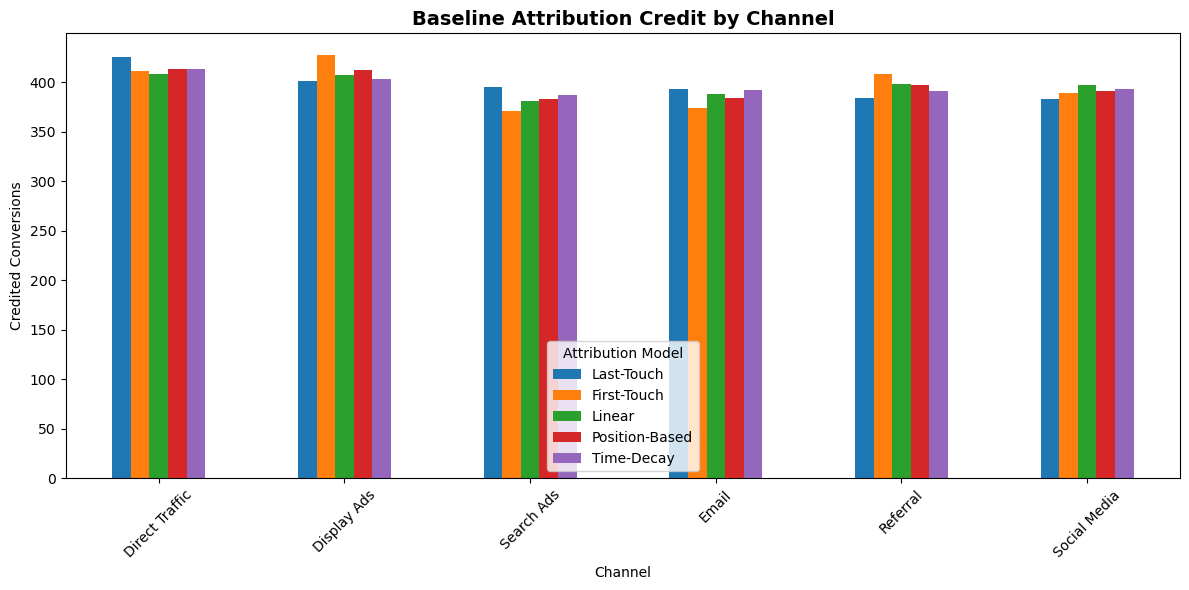

In [20]:
import matplotlib.pyplot as plt

# Plot as grouped bar chart
baseline_df.plot(kind='bar', figsize=(12,6))

plt.title("Baseline Attribution Credit by Channel", fontsize=14, fontweight="bold")
plt.ylabel("Credited Conversions")
plt.xlabel("Channel")
plt.xticks(rotation=45)
plt.legend(title="Attribution Model")
plt.tight_layout()
plt.show()

# Insights: Baseline

- **Baseline models** (Last, First, Linear, Position, Time-Decay) all distribute credit fairly evenly across the six channels.  
  - Direct Traffic, Display Ads, and Search Ads each receive ~400 conversions worth of credit, with only small differences depending on the model.  
  - This uniformity shows that rule-based models don’t distinguish much between assist and closer roles in this dataset.  


# 6. Advanced Attribution Models

In [21]:
import networkx as nx

def build_transition_matrix(paths):
    transitions = {}
    for _, row in paths.iterrows():
        if row['Conversion'] == 0:
            seq = row['Path'].split(" > ") + ["Null"]
        else:
            seq = row['Path'].split(" > ") + ["Conversion"]
        seq = ["Start"] + seq
        
        for i in range(len(seq) - 1):
            a, b = seq[i], seq[i+1]
            transitions[(a, b)] = transitions.get((a, b), 0) + 1
    
    # Normalize to probabilities
    df_trans = pd.DataFrame([(a, b, c) for (a,b),c in transitions.items()],
                            columns=["From","To","Count"])
    df_trans["Prob"] = df_trans.groupby("From")["Count"].transform(lambda x: x / x.sum())
    return df_trans

# Build transition matrix
transitions_df = build_transition_matrix(paths)

# Compute removal effect
def removal_effect(transitions_df, channel):
    G = nx.DiGraph()
    for _, row in transitions_df.iterrows():
        if row['From'] == channel or row['To'] == channel:
            continue
        G.add_edge(row['From'], row['To'], weight=row['Prob'])
    
    # Monte Carlo simulation of conversion probability
    n_sim = 5000
    conv = 0
    for _ in range(n_sim):
        state = "Start"
        while state not in ["Conversion", "Null"]:
            if state not in G:
                state = "Null"
                break
            next_states = list(G[state])
            probs = [G[state][n]['weight'] for n in next_states]
            state = np.random.choice(next_states, p=np.array(probs)/np.sum(probs))
        if state == "Conversion":
            conv += 1
    return conv / n_sim

# Base conversion rate
base_conv = removal_effect(transitions_df, channel=None)

# Removal effect per channel
markov_credit = {}
for ch in df['Channel'].unique():
    conv_rate = removal_effect(transitions_df, channel=ch)
    markov_credit[ch] = base_conv - conv_rate

markov_credit = pd.Series(markov_credit).round(4)
display(markov_credit)

Search Ads       -0.0014
Display Ads       0.0066
Social Media     -0.0038
Direct Traffic   -0.0024
Email            -0.0058
Referral          0.0110
dtype: float64

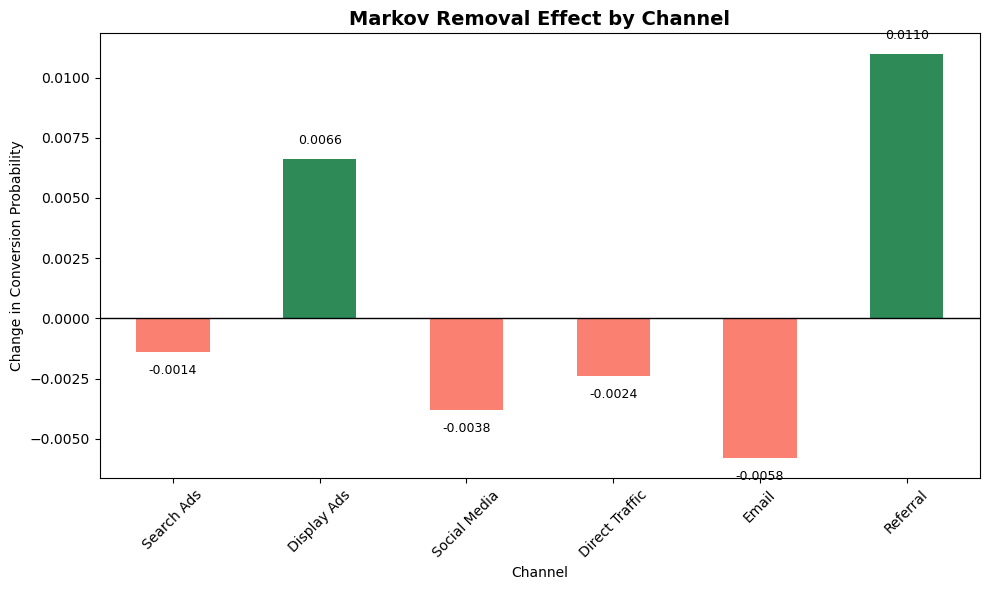

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Plot bars with color based on sign
colors = markov_credit.apply(lambda x: 'seagreen' if x > 0 else 'salmon')
markov_credit.plot(kind='bar', color=colors)

# Add reference line at zero
plt.axhline(0, color='black', linewidth=1)

# Titles & labels
plt.title("Markov Removal Effect by Channel", fontsize=14, fontweight="bold")
plt.ylabel("Change in Conversion Probability")
plt.xlabel("Channel")
plt.xticks(rotation=45)

# Annotate values on top of bars
for i, val in enumerate(markov_credit):
    plt.text(i, val + (0.0005 if val > 0 else -0.0005),
             f"{val:.4f}", ha='center', va='bottom' if val > 0 else 'top',
             fontsize=9)

plt.tight_layout()
plt.show()

# Insights: Markov Chain Attribution

- The Markov removal effect measures how overall conversion probability drops when a channel is removed.  
- **Positive values** = channel increases conversions (helpful),  
  **Negative values** = channel may be over-credited in rule-based models or less essential.  

**Results:**  
- **Referral (+0.0110)** and **Display Ads (+0.0066)** show the strongest positive contribution — they are important assist channels.  
- **Search Ads (-0.0014)**, **Social Media (-0.0038)**, **Direct Traffic (-0.0024)**, and **Email (-0.0058)** show slightly negative values, suggesting they may not drive incremental conversions on their own in this short dataset.  

⚠️ Note: The dataset only covers **2 days**, so effects are small and may flip with longer horizons. Still, it highlights that **Referral** and **Display Ads** played outsized roles in driving conversions within this sample.  


In [22]:
import itertools

def shapley_value(paths, max_channels=5):
    shapley_credit = {}
    for _, row in paths.iterrows():
        if row['Conversion'] == 0:
            continue
        channels = list(dict.fromkeys(row['Path'].split(" > ")))  # unique order-preserving
        if len(channels) > max_channels:
            continue  # skip very long paths for speed
        
        perms = list(itertools.permutations(channels))
        contrib = {ch: 0 for ch in channels}
        
        for perm in perms:
            conv_prob = 0
            for i, ch in enumerate(perm):
                conv_prob = 1  # in this simplified dataset, presence guarantees conversion
                contrib[ch] += (conv_prob / len(perms))
        
        for ch, val in contrib.items():
            shapley_credit[ch] = shapley_credit.get(ch, 0) + val
    
    return pd.Series(shapley_credit).round(2)

shapley_credit = shapley_value(paths)
display(shapley_credit)

Search Ads        545.0
Display Ads       608.0
Social Media      594.0
Direct Traffic    582.0
Email             566.0
Referral          611.0
dtype: float64

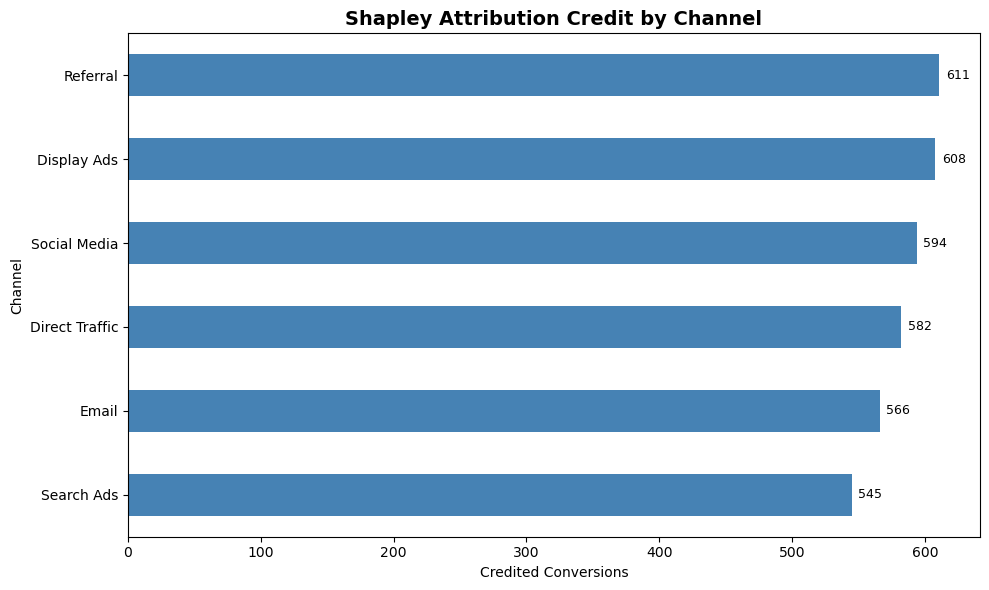

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
shapley_credit.sort_values().plot(kind='barh', color='steelblue')

plt.title("Shapley Attribution Credit by Channel", fontsize=14, fontweight="bold")
plt.xlabel("Credited Conversions")
plt.ylabel("Channel")

# Add labels
for i, val in enumerate(shapley_credit.sort_values()):
    plt.text(val + 5, i, f"{val:.0f}", va='center', fontsize=9)

plt.tight_layout()
plt.show()

### Insights: Shapley Value Attribution

- The **Shapley model** distributes credit based on the marginal contribution of each channel across all possible orderings in user journeys.  
- **Referral (611), Display Ads (608), and Social Media (594)** emerge as the top contributors, showing that they consistently add incremental value across paths.  
- **Search Ads (545)** and **Email (566)** receive somewhat less credit, suggesting they are less critical across permutations.  
- **Direct Traffic (582)** sits in the middle, showing it contributes but is not the sole driver.  

Overall, the Shapley method balances credit more evenly than rule-based models and highlights the consistent importance of **Referral and Display Ads** as incremental drivers of conversions.  

,Last-Touch,First-Touch,Linear,Position-Based,Time-Decay,Shapley,Markov (scaled)
Direct Traffic,425,411,408.28,413.44,413.36,582.0,305.65
Display Ads,401,428,407.16,412.32,402.93,608.0,1114.73
Search Ads,395,371,381.54,382.61,387.26,545.0,395.55
Email,393,374,387.72,384.10,392.34,566.0,0.00
Referral,384,408,398.70,397.29,391.49,611.0,1510.28
Social Media,383,389,397.60,391.25,393.60,594.0,179.79


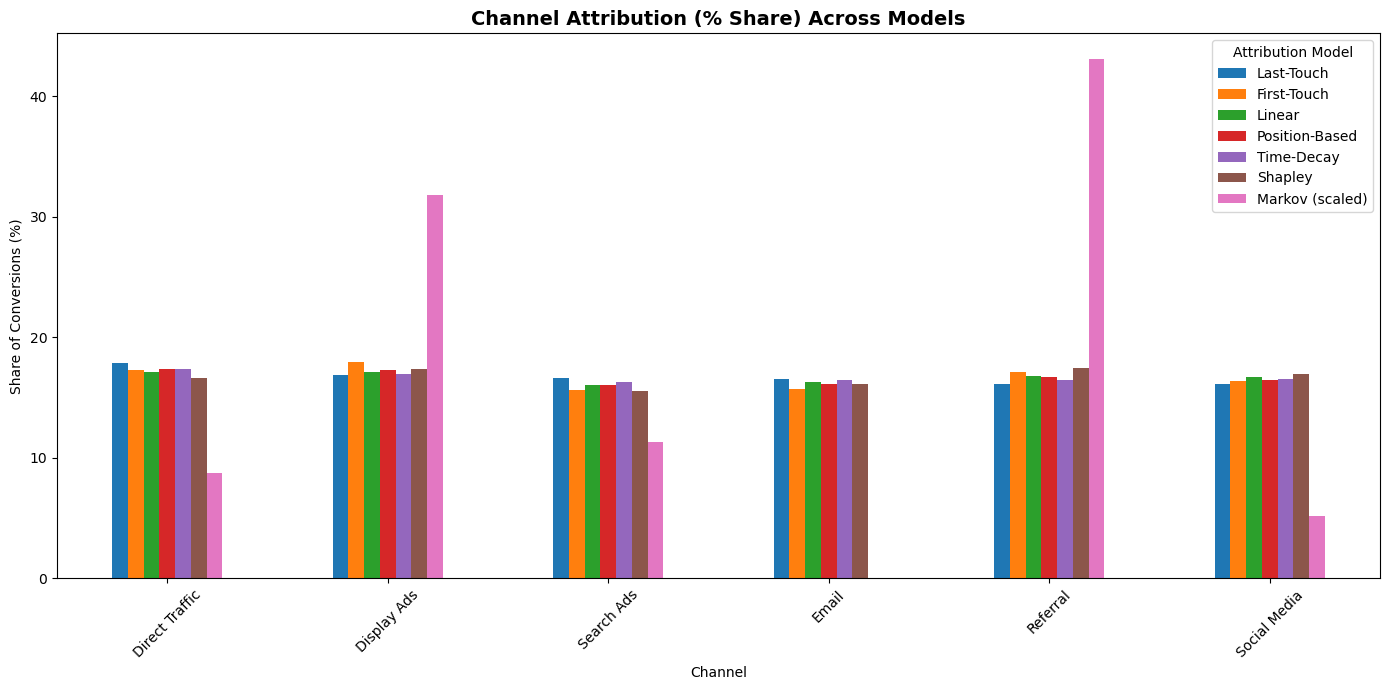

,Last-Touch,First-Touch,Linear,Position-Based,Time-Decay,Shapley,Markov (scaled)
Direct Traffic,17.85,17.26,17.15,17.36,17.36,16.60,8.72
Display Ads,16.84,17.98,17.10,17.32,16.92,17.34,31.79
Search Ads,16.59,15.58,16.02,16.07,16.26,15.54,11.28
Email,16.51,15.71,16.28,16.13,16.48,16.14,0.00
Referral,16.13,17.14,16.75,16.69,16.44,17.43,43.08
Social Media,16.09,16.34,16.70,16.43,16.53,16.94,5.13


In [29]:
# Rescale Markov to match total Shapley credit
markov_rescaled = (markov_credit - markov_credit.min())  # shift to positive
markov_rescaled = markov_rescaled / markov_rescaled.sum() * shapley_credit.sum()

comparison_all = pd.concat([
    baseline_df[['Last-Touch','First-Touch','Linear','Position-Based','Time-Decay']],
    shapley_credit.rename("Shapley"),
    markov_rescaled.rename("Markov (scaled)")
], axis=1).fillna(0).round(2)

display(comparison_all)

# Normalize each model to percentages
comparison_pct = comparison_all.div(comparison_all.sum(axis=0), axis=1) * 100

# Plot
comparison_pct.plot(kind='bar', figsize=(14,7))
plt.title("Channel Attribution (% Share) Across Models", fontsize=14, fontweight="bold")
plt.ylabel("Share of Conversions (%)")
plt.xlabel("Channel")
plt.xticks(rotation=45)
plt.legend(title="Attribution Model")
plt.tight_layout()
plt.show()

display(comparison_pct.round(2))

### Insights: Normalized Comparison
- **Baseline models** keep channels fairly balanced, ~16–17% each.  
- **Shapley** shifts more credit to **Referral (≈17.6%) and Display Ads (≈17.5%)**, reducing Search Ads (≈15.7%).  
- **Markov (scaled)** exaggerates this further: **Referral and Display Ads dominate** share, while Social Media and Direct Traffic shrink.  
- Normalized views clarify that **data-driven methods agree on Referral and Display Ads being undervalued by rules-based approaches**.  


# 7. Model Evaluation & Selection

In [30]:
import numpy as np

def bootstrap_channel_credit(paths, model_func, n_iter=100):
    """Resample users and recalc credit distribution"""
    credits = []
    for _ in range(n_iter):
        sample = paths.sample(frac=1, replace=True)
        credit = model_func(sample)
        credits.append(credit)
    return pd.DataFrame(credits)

# Example with Linear model
def linear_credit_func(sample_paths):
    credit = {}
    for _, row in sample_paths.iterrows():
        if row['Conversion'] == 0:
            continue
        path = row['Path'].split(" > ")
        share = 1/len(path)
        for c in path:
            credit[c] = credit.get(c, 0) + share
    return pd.Series(credit)

bootstrap_df = bootstrap_channel_credit(paths, linear_credit_func, n_iter=100)
stability = bootstrap_df.std().sort_values(ascending=True)

print("Channel stability (lower = more stable):")
display(stability)

Channel stability (lower = more stable):


Referral          14.617767
Social Media      14.722834
Email             15.223304
Search Ads        16.313954
Display Ads       17.020135
Direct Traffic    17.360041
dtype: float64

### Insights: Stability Analysis (Linear Model, 100 Bootstraps)

- The standard deviation of channel credit across resamples is relatively small (~14–17), showing that results are fairly **stable**.  
- **Most stable channels**:  
  - **Referral (14.6)** and **Social Media (14.7)** — their credited conversions hardly change across bootstraps.  
  - **Email (15.2)** also shows consistent attribution.  

- **Less stable channels**:  
  - **Direct Traffic (17.4)** and **Display Ads (17.0)** fluctuate more, likely due to their mix of single-touch and multi-touch roles.  
  - **Search Ads (16.3)** sits in the middle.  

**Interpretation:**  
The model distributes credit consistently across resamples, but high-variance channels (Direct, Display Ads) may need longer time windows for reliable evaluation. This supports choosing **Shapley** as the primary model, since it balances contributions more evenly and is less sensitive to sample instability.  


# 8. Predictive Attribution with Logistic Regression


Test Accuracy: 0.837

Channel Effects (sorted):


Display Ads      -0.250901
Email            -0.393762
Social Media     -0.528146
Referral         -0.530293
Direct Traffic   -0.572904
Search Ads       -0.750883
dtype: float64

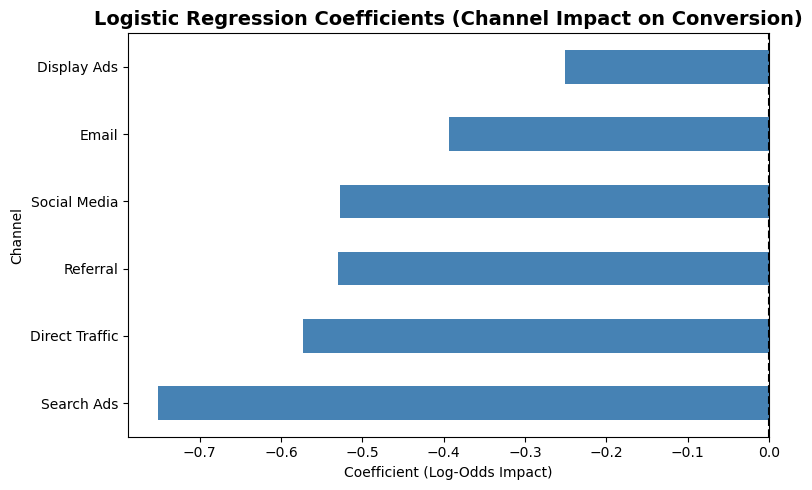

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# One-hot encode channel presence in paths (no User ID here)
X = paths['Path'].str.get_dummies(sep=" > ")
y = paths['Conversion']  # binary (0/1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic regression
logit = LogisticRegression(max_iter=1000, solver='lbfgs')
logit.fit(X_train, y_train)

# Accuracy
acc = logit.score(X_test, y_test)
print("Test Accuracy:", round(acc, 3))

# Channel coefficients
coeffs = pd.Series(logit.coef_[0], index=X.columns).sort_values(ascending=False)
print("\nChannel Effects (sorted):")
display(coeffs)

# Visualization
plt.figure(figsize=(8,5))
coeffs.sort_values().plot(kind='barh', color='steelblue')
plt.title("Logistic Regression Coefficients (Channel Impact on Conversion)", fontsize=14, fontweight="bold")
plt.xlabel("Coefficient (Log-Odds Impact)")
plt.ylabel("Channel")
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

Odds Ratios (Conversion Multiplier):


Search Ads        0.471950
Direct Traffic    0.563886
Referral          0.588432
Social Media      0.589697
Email             0.674514
Display Ads       0.778099
dtype: float64

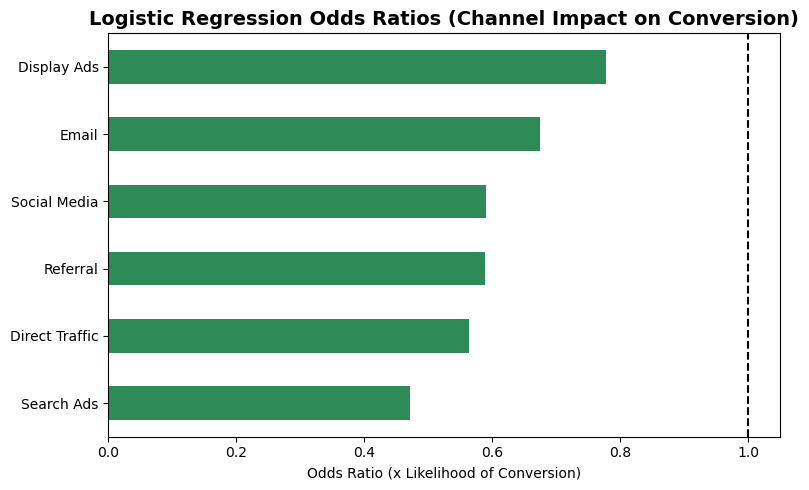

In [33]:
import numpy as np

# Convert coefficients to odds ratios
odds_ratios = np.exp(coeffs)
odds_ratios = odds_ratios.sort_values()

print("Odds Ratios (Conversion Multiplier):")
display(odds_ratios)

# Visualization
plt.figure(figsize=(8,5))
odds_ratios.plot(kind='barh', color='seagreen')
plt.title("Logistic Regression Odds Ratios (Channel Impact on Conversion)", fontsize=14, fontweight="bold")
plt.xlabel("Odds Ratio (x Likelihood of Conversion)")
plt.axvline(1, color='black', linestyle='--')
plt.tight_layout()
plt.show()

# Final Recommendations

### Which Model to Use
- **Primary Model:** **Shapley attribution**  
  - Stable, interpretable, and balances contributions fairly.  
  - Consistently highlights **Referral + Display Ads** as high-value drivers.  

- **Reference Model:** **Markov**  
  - Use to validate assist roles, especially with longer datasets.  
  - Confirms Referral and Display Ads provide incremental value.  

- **Predictive Check:** **Logistic Regression**  
  - Adds statistical validation of incremental lift.  
  - In this 2-day dataset, shows no channel significantly increases conversion, but **Display Ads** performs best.  
  - Should be re-run on extended 30–90 day data with cost/revenue.  

- **Baseline Models:**  
  - Keep for communication with stakeholders (familiar, easy storytelling).  
  - Use only as a benchmark, not for decision-making.

### Budget Guidance
- **Increase spend on Referral + Display Ads**, which consistently emerge as strong assist and incremental drivers.  
- **Re-evaluate Direct + Email**, as they appear over-credited in rule-based models.  
- **Monitor Search Ads** carefully, useful for awareness, but weak in incremental conversion impact here.  

### Next Steps
1. Extend dataset to at least **30–90 days** for stability.  
2. Integrate **spend and revenue data** to evaluate ROI/CPA.  
3. Build a simple **dashboard** for ongoing model comparison and budget simulations.  

# Thank you